Auto-encoding variational bayes, inspired from Keras website.
https://arxiv.org/abs/1312.6114

In [1]:
import sys
import os
sys.path.append("..")
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from vae_cnn import VAE
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
p = sns.color_palette("Set2")
sns.palplot(p)
sns.set_palette(p)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
cmap = plt.cm.get_cmap('Spectral')
c_10 = [cmap(i/10) for i in range(1, 11)]

In [18]:
IMG_SIZE = 28
SYNTHETIC_PATH = '../Results/Synthetic/'
MODEL_NAME = 'dcvae'
LATENT_DIM = 8

In [3]:
class DataStructure:

    def __init__(self):
        x_train, x_test, y_train, y_test, img_size = self.load_mnist()
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.img_size = img_size


    def load_mnist(self):
        # MNIST dataset -> VAE
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        img_size = x_train.shape[1]
        x_train = np.reshape(x_train, [-1, img_size, img_size, 1])
        x_test = np.reshape(x_test, [-1, img_size, img_size, 1])
        x_train = x_train.astype('float32') / 255
        x_test = x_test.astype('float32') / 255
        return x_train, x_test, y_train, y_test, img_size

In [4]:
data = DataStructure()
model = VAE(data)
model.build_vae()
model.load(1500)

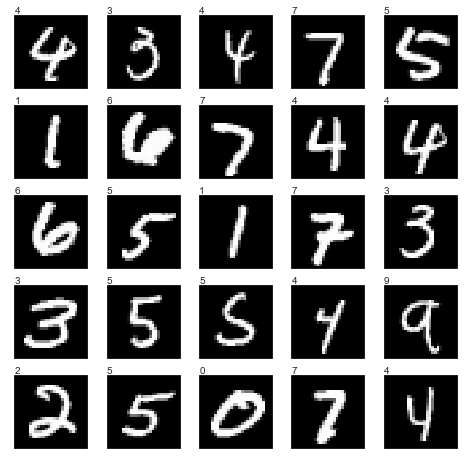

In [5]:
def plot_original():
    n = 25
    x_train = data.x_train[:, :, :, 0]
    y_train = data.y_train
    ids = np.random.choice(len(x_train), n)
    samples = x_train[ids]
    labels = y_train[ids]
    fig, axis = plt.subplots(ncols=int(n/5), nrows=int(5), figsize=(8, 8))
    no_ticks = dict(left=False, bottom=False, labelleft=False, labelbottom=False)
    for i in range(len(axis)):
        for j, ax in enumerate(axis[i - 1]):
            index = i*5 + j
            ax.imshow(samples[index], cmap='gray')
            ax.annotate(int(labels[index]), xy=(3, 1), xytext=(0, -0.5))
            ax.tick_params(axis='both', which='both', **no_ticks)
            ax.grid(None)
    plt.savefig('mnist-dataset.png', bbox_inches='tight', pad_inches=0)
    plt.show()

plot_original()

In [6]:
def find_nearest_z(zs, z_pred):
    labels = []
    for z in zs:
        z_pred = np.asarray(z_pred)
        dist = np.sum((z_pred - z)**2, axis=1)
        labels.append(np.argmin(dist))
    return labels

def to_rgb(imgs, labels):
    n = imgs.shape[0]
    rgb_imgs = np.zeros(shape=(n, IMG_SIZE, IMG_SIZE, 3))
    for i, img in enumerate(imgs):
        if labels is None:
            color = (1, 1, 1)
        else:
            color = c_10[labels[i]]
        rgb_imgs[i, :, :, 0] = img * color[0]
        rgb_imgs[i, :, :, 1] = img * color[1]
        rgb_imgs[i, :, :, 2] = img * color[2]
    return rgb_imgs
a = to_rgb(data.x_train[:, :, :, 0][:1], data.y_train)

In [7]:
def plot_latent(model, xs, ys, n, xlim, ylim, markersize=20):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    zs, _, _ = model.encoder.predict(data.x_test)
    labels = data.y_test
    for i in range(10):
        ids = np.where(labels == i)[0]
        x = zs[ids]
        y = zs[ids]
        ax1.scatter(x=x[:,0], y=y[:,1], label=str(i), s=markersize, c=c_10[i])
    ax1.legend(markerscale=1)
    if (xlim is not None) and (ylim is not None):
        ax1.set_xlim(xlim)
        ax1.set_ylim(ylim)
    ax1.set_xlabel('z1')
    ax1.set_ylabel('z2')
    plot_manifold(model, xs, ys, n, zs, ax2)
    plt.savefig('vae-mnist-latent.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    
def plot_manifold(model, xs, ys, n, z_pred=None, axis=None):
    if axis is None:
        fig = plt.figure(figsize=(16, 16))
    f = np.zeros(shape=(IMG_SIZE * n, IMG_SIZE * n, 3))
    zs = []
    for r in np.linspace(ys[0], ys[1], n):
        for c in np.linspace(ys[1], ys[0], n):
            zs.append([r, c])
    zs = np.array(zs)  
    x_decoded = model.decoder.predict(zs)
    if z_pred is None:
        labels = None
    else:
        labels = data.y_test[find_nearest_z(zs, z_pred)]
    x_decoded = to_rgb(x_decoded[:, :, :, 0], labels)
    x_decoded = x_decoded.reshape(n, n, IMG_SIZE, IMG_SIZE, 3)
    for r in range(n):
        for c in range(n):
            f[r*IMG_SIZE: (r+1)*IMG_SIZE, c*IMG_SIZE:(c+1)*IMG_SIZE, :] = x_decoded[c][r]
    for r in range(0, IMG_SIZE * n, IMG_SIZE):
        f[r, :] = 0
    for c in range(0, IMG_SIZE * n, IMG_SIZE):
        f[:, c] = 0
    plt.axis('off')
    if axis is not None:
        axis.imshow(f)
    else:  
        plt.imshow(f)

In [9]:
#plot_latent(model, (-3, 3), (-3, 3), 20, [-3.5, 3.5], [-4.5, 4.5])  # Only if latent dim = 2

In [12]:
#plot_manifold(model, (-3, 3), (-4, 4), 30, None)  # big manifold  # Only if latent dim = 2
#plt.savefig('vae-mnist-big-manifold.png', bbox_inches='tight', pad_inches=0)  # Only latent dime = 2

In [25]:
def generate_real(n):
    ids = np.random.choice(data.x_train.shape[0], n, replace=False)
    imgs = data.x_train[ids][:, :, :, 0]
    np.save(SYNTHETIC_PATH + 'mnist_' + str(n) + '.npy', imgs)
    

def generate_synthetic(n, save=True):
    images = np.zeros(shape=(n, 28, 28))
    x_decoded = model.decoder.predict(np.random.normal(size=(n, LATENT_DIM)))
    for i, img in enumerate(x_decoded):
        img = img.reshape(28, 28)
        images[i] = img
    if save:
        np.save(SYNTHETIC_PATH + MODEL_NAME + '_' + str(n) + '_l' + str(LATENT_DIM) + '.npy', images)
    else: return images

    
def compare_to_original(model, n_samples=20):
    real_images = model.data.x_test[np.random.choice(len(model.data.x_test), n_samples)]
    z_mean, z_log_var, z = model.encoder.predict(real_images, batch_size=model.batch_size)
    fig = plt.figure(figsize=(16,2))
    axis = []
    for i in range(1, 3 * n_samples + 1):
        ax = fig.add_subplot(3, n_samples, i)
        ax.grid(False)
        ax.axis('off')
        axis.append(ax)
    for i, a in enumerate(axis[:n_samples]):
        a.imshow(real_images[i][:, :, 0], cmap='gray')
    for i, a in enumerate(axis[n_samples: 2*n_samples]):
        synthetic_image = model.decoder.predict(np.array([z[i]]))
        a.imshow(synthetic_image[0][:,:,0], cmap='gray')
    random_imgs = generate_synthetic(20, save=False)
    for i, a in enumerate(axis[2*n_samples:]):
        a.imshow(random_imgs[i], cmap='gray')
    plt.savefig('vae-mnist-comparison.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    return

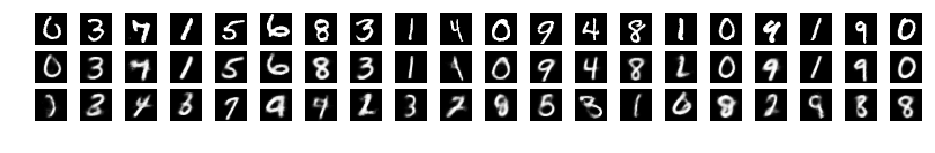

In [27]:
compare_to_original(model)

In [24]:
imgs = generate_synthetic(1000)

In [84]:
generate_real(2000)